In [243]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
%matplotlib inline

In [244]:
#GET COIN DATA AND ADD PERCENTAGES CHANGES TO DF
def get_historic_price(symbol, exchange='hitbtc', after='2016-04-01'):
    url = 'https://api.cryptowat.ch/markets/{exchange}/{symbol}usdt/ohlc'.format(symbol=symbol, 
                                                                                 exchange=exchange)
    resp = requests.get(url, params={'periods': time_interval, 
                                     'after': str(int(pd.Timestamp(after).timestamp()))})
    resp.raise_for_status()
    data = resp.json()
    df = pd.DataFrame(data['result'][time_interval], columns=['CloseTime', 'OpenPrice', 
                                                              'HighPrice', 'LowPrice', 
                                                              'ClosePrice', 'Volume', 'NA'])
    df['CloseTime'] = pd.to_datetime(df['CloseTime'], unit='s')
    df.set_index('CloseTime', inplace=True)
    df = df.drop(['NA'], axis=1)
    df_perc = df.pct_change()*100
    df_merged = pd.merge(left=df, right=df_perc, left_index=True, right_index=True)
    df_merged = df_merged.rename(columns={"OpenPrice_x":"OpenPrice",
                                          "HighPrice_x":"HighPrice", 
                                          "LowPrice_x":"LowPrice", 
                                          "ClosePrice_x":"ClosePrice", 
                                          "Volume_x":"Volume",
                                          "OpenPrice_y":"OpenPricePerc",
                                          "HighPrice_y":"HighPricePerc", 
                                          "LowPrice_y":"LowPricePerc", 
                                          "ClosePrice_y":"ClosePricePerc", 
                                          "Volume_y":"VolumePerc"})
    return df_merged

In [245]:
#GET DATAFRAME DICTIONARY OF COINS
df_coins = {}
time_interval = '3600'   # Minute: 60, Hour: 3600, 4-Hours: 14400,  Day: 86400
time_length = 365*2        #time length going back from today in days
exchange = 'hitbtc'      #crypto exchange name

"""
coin_pairs = ['btc', 'eth', 'bnb', 'xrp', 'ada', 'dot', 'uni', 'ltc', 'bch', 'link', 'vet', 'xlm', 'fil', 'theta', 'trx', 'xmr', 'gas', 'neo', 
              'luna', 'eos', 'klay', 'btt', 'bsv', 'cro', 'ftt', 'cake', 'aave', 'atom', 'mkr', 'etc', 'xtz', 'algo', 'ht', 'comp', 'rune', 'ksm', 
              'dash', 'xem', 'zec', 'dcr', 'hbar', 'stx', 'nexo', 'mana', 'enj', 'dgb', 'zil', 'iota', 'iost', 'bat', 'grt', 'snx', 'near', 'yfi', 
              'btg', 'waves', 'sushi', 'doge', 'uma', 'qtum', 'etc', 'ont', 'omg', 'zil', 'lsk', 'ocean']
"""
#for hitbtc according to volume: https://coinmarketcap.com/exchanges/hitbtc/
coin_pairs = ['btc', 'eth', 'trx', 'xrp', 'ltc', 'eos', 'bsv', 'xlm', 'neo', 'zec', 
              'ada', 'dash', 'bch', 'ont', 'xem', 'omg', 'zil', 'xmr', 'xtz', 'iota',
              'iost', 'zrx', 'doge', 'icx', 'brg', 'lsk', 'etc', 'zen', 'mkr', 'utk']

for coin_name in coin_pairs:
    try:
        from_when = (pd.Timestamp.now() - pd.offsets.Day(time_length))
        df_coin = get_historic_price(coin_name, exchange, after=from_when)
        #print("Coin:", coin_name)
        df_coins[coin_name] = df_coin
    except:
        print("ERROR! Check:", coin_name)

In [246]:
coin = 'eth'
df = df_coins[coin]

In [251]:
n=3
base_strength = .05
time_to_top = 12

df['Minima'] = df.iloc[argrelextrema(df.LowPrice.values, np.less_equal, order=n)[0]]['LowPrice']
df['NextTop'] = df['HighPrice'].rolling(time_to_top, min_periods=1).max().shift(-time_to_top)
df['BaseRise'] = (df.NextTop-df.Minima)/df.Minima
df.loc[ (df['BaseRise']>=base_strength), 'BaseStrength'] = 'Strong'
df.loc[ (df['BaseRise']< base_strength), 'BaseStrength'] = 'Weak'

In [252]:
df["RealBase"] = df[df['BaseStrength']=='Strong']['Minima']

In [253]:
df = df.loc['2021-05-07':'2021-05-17'].copy()

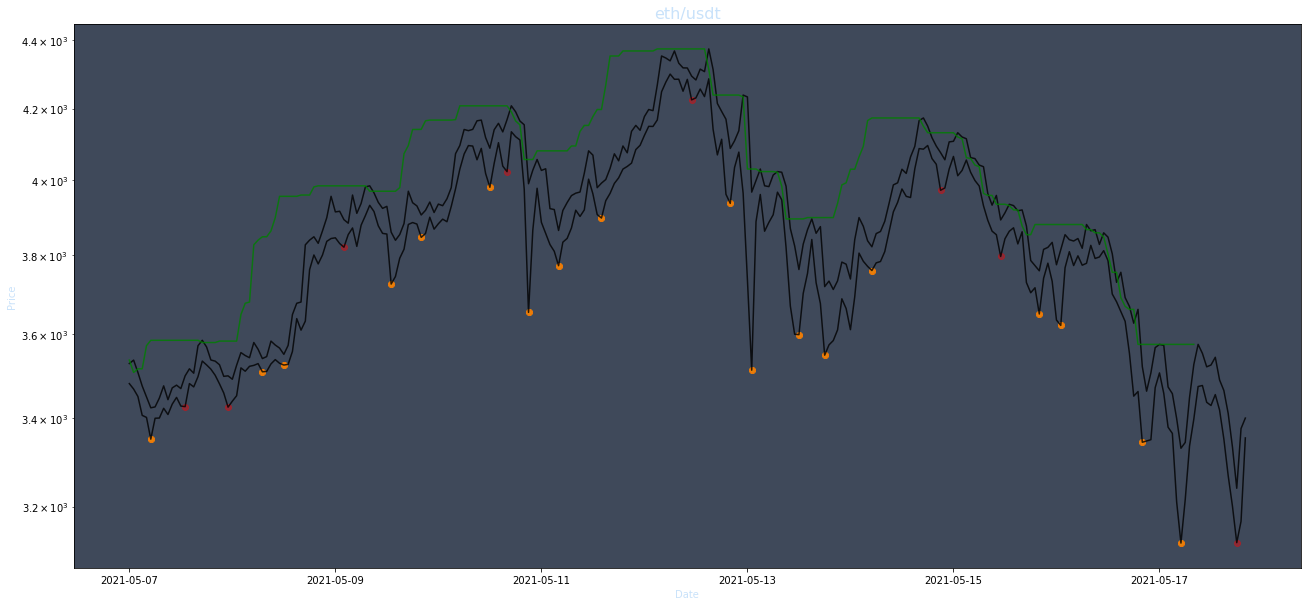

In [254]:
fig, ax = plt.subplots(figsize=(22, 10))
ax.set_yscale('log')
ax.set_xlabel('Date',size=10, color="#C9E2FA")     # set x-axis label and specific size
ax.set_ylabel('Price',size=10, color="#C9E2FA")    # set y-axis label and specific size
ax.set_title(coin+'/usdt',size=16, color="#C9E2FA") # set plot title with specific size

ax.set_facecolor("#3F495A") 
ax.plot(df.index, df.HighPrice, color='black', alpha=0.8)
ax.plot(df.LowPrice, color='black', alpha=0.8)
ax.plot(df.NextTop, color='green', alpha=0.8)


ax.scatter(df.index, df['RealBase'], c='yellow', alpha=0.8)  
ax.scatter(df.index, df['Minima'], c='red', alpha=0.4)  